In [12]:
import cv2
import numpy as np

img = cv2.imread("dogs.jpg")                        # BGR format
img = cv2.resize(img, (640, 640))                    # Resize to model input
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
img = img/255       
img = img.astype(np.float32)                         # Ensure uint8
img.tofile("input.raw")                              # Save as raw binary

In [ ]:
# snpe-net-run --container yolov8n-seg-quantized.dlc --input_list input_list.txt

# snpe-net-run --input_list input_list.txt --container yolov8n-seg.dlc --output_dir output

# snpe-net-run --container yolov8n-seg.dlc --input_list input_list.txt --output_dir output --set_output_tensors="yolov8n-seg output0,output1"

(819200,)
This is output1: shape (1, 160, 160, 32)

In [88]:
import numpy as np

# Load the raw file
data = np.fromfile("results1/Result_0/output0.raw", dtype=np.float32)

print(data.shape)
# Try interpreting as both possible shapes
size_output0 = 1 * 116 * 8400
size_output1 = 1 * 160 * 160 * 32

if data.size == size_output0:
    print("This is output0: shape (1, 116, 8400)")
elif data.size == size_output1:
    print("This is output1: shape (1, 160, 160, 32)")
else:
    print(f"Unknown tensor size: {data.size}")

(974400,)
This is output0: shape (1, 116, 8400)


In [ ]:
output0 = np.fromfile("results/Result_0/output0.raw", dtype=np.float32).reshape(1, 116, 8400)
output1 = np.fromfile("results/Result_0/output1.raw", dtype=np.float32).reshape(1, 160, 160, 32)

print("Sample bounding box (first anchor):", output0[0, 0:4, 0])  # cx, cy, w, h
print("Sample class scores (first anchor):", output0[0, 4:84, 0])
print("Sample mask coeffs (first anchor):", output0[0, 84:, 0])


Sample bounding box (first anchor): [     5.2108      4.7897      10.372      9.4687]
Sample class scores (first anchor): [ 3.2148e-05  1.5032e-06  3.5872e-06  1.3238e-06  3.2079e-07  5.7695e-07  7.9434e-07  9.4246e-07  9.7089e-07   5.563e-07  3.5297e-07  5.2624e-07  1.0208e-06  2.3417e-06    7.05e-07  1.9349e-06  1.1165e-06  1.0422e-06  1.1911e-06  1.7474e-06  8.5728e-07  3.7263e-07   9.611e-07  4.1002e-07  2.3446e-06  8.7811e-07
  1.6337e-06  1.3252e-06  1.4687e-06  3.5284e-07  6.9879e-07  4.5141e-07  9.2642e-07  1.2759e-07  5.0152e-07  2.0345e-07  2.2973e-07  7.1214e-07  4.9796e-07  3.0972e-06  1.9737e-06  5.0682e-06  1.3043e-06  1.8745e-06   1.933e-06  3.9948e-06  1.0901e-06  1.1751e-06  4.9806e-07  6.8039e-07  1.2037e-06  4.7544e-07
  4.0683e-07  6.3893e-07  1.4366e-06  9.4228e-07  1.0413e-05  3.0764e-06  2.1378e-06  1.4929e-06   4.099e-06  1.5382e-06  2.4299e-06  1.0721e-06  9.6679e-07  7.8518e-07  1.1008e-06  1.1791e-06   1.173e-06  2.7347e-06  4.8234e-07  3.3178e-06  2.0061e-06

Saved to output_folder/segmentation_results.jpg


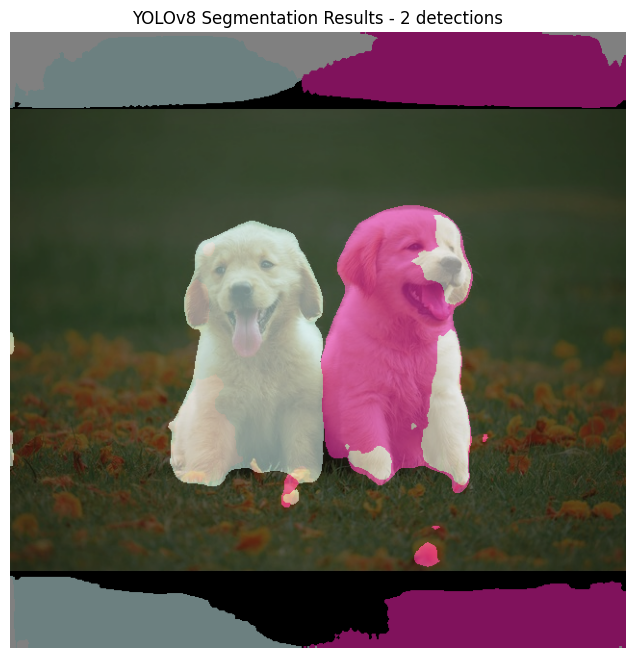


Detection Summary:
  1. dog: 0.743
  2. dog: 0.609


In [60]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from typing import Tuple, Optional

class YOLOv8SegmentationPostProcessor:
    def __init__(self, 
                 conf_threshold: float = 0.5, 
                 nms_threshold: float = 0.4,
                 input_size: Tuple[int, int] = (640, 640)):
        self.conf_threshold = conf_threshold
        self.nms_threshold = nms_threshold
        self.input_size = input_size
        
        self.class_names = [
            'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
            'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
            'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
            'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
            'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
            'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
            'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
            'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
            'hair drier', 'toothbrush'
        ]
        
    def load_raw_outputs(self, output0_path: str, output1_path: str) -> Tuple[np.ndarray, np.ndarray]:
        output0 = np.fromfile(output0_path, dtype=np.float32).reshape(1, 116, 8400)
        output1 = np.fromfile(output1_path, dtype=np.float32).reshape(1, 160, 160, 32)
        return output0, output1

    def decode_predictions(self, output0: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        predictions = output0[0]  # [116, 8400]
        boxes = predictions[:4, :]
        scores = predictions[4:84, :]
        mask_coeffs = predictions[84:, :]

        x_center, y_center, width, height = boxes
        x1 = x_center - width / 2
        y1 = y_center - height / 2
        x2 = x_center + width / 2
        y2 = y_center + height / 2
        boxes_xyxy = np.stack([x1, y1, x2, y2], axis=0)

        return boxes_xyxy, scores, mask_coeffs

    def filter_predictions(self, boxes, scores, mask_coeffs):
        max_scores = np.max(scores, axis=0)
        max_classes = np.argmax(scores, axis=0)
        valid_mask = max_scores > self.conf_threshold

        return (
            boxes[:, valid_mask],
            max_scores[valid_mask],
            max_classes[valid_mask],
            mask_coeffs[:, valid_mask]
        )

    def apply_nms(self, boxes, scores, classes, mask_coeffs):
        if len(scores) == 0:
            return boxes, scores, classes, mask_coeffs

        boxes_xywh = np.stack([
            boxes[0],
            boxes[1],
            boxes[2] - boxes[0],
            boxes[3] - boxes[1]
        ], axis=1)

        indices = cv2.dnn.NMSBoxes(
            bboxes=boxes_xywh.tolist(),
            scores=scores.tolist(),
            score_threshold=self.conf_threshold,
            nms_threshold=self.nms_threshold
        )

        if len(indices) > 0:
            indices = indices.flatten()
            return (
                boxes[:, indices],
                scores[indices],
                classes[indices],
                mask_coeffs[:, indices]
            )
        else:
            return (
                np.empty((4, 0)),
                np.empty((0,)),
                np.empty((0,)),
                np.empty((32, 0))
            )

    def generate_masks(self, mask_coeffs, proto_masks):
        if mask_coeffs.shape[1] == 0:
            return np.empty((0, 160, 160))
        proto_masks = proto_masks[0]  # [160, 160, 32]
        masks = np.einsum("hwd,dn->hwn", proto_masks, mask_coeffs)
        masks = 1 / (1 + np.exp(-masks))  # sigmoid
        masks = masks.transpose(2, 0, 1)  # [N, H, W]
        return masks

    def scale_coordinates(self, boxes: np.ndarray, original_shape: Tuple[int, int]) -> np.ndarray:
        orig_h, orig_w = original_shape
        input_w, input_h = self.input_size

        gain = min(input_w / orig_w, input_h / orig_h)
        pad_w = (input_w - orig_w * gain) / 2
        pad_h = (input_h - orig_h * gain) / 2

        boxes_scaled = boxes.copy()
        boxes_scaled[[0, 2]] -= pad_w
        boxes_scaled[[1, 3]] -= pad_h
        boxes_scaled /= gain

        boxes_scaled[0::2] = boxes_scaled[0::2].clip(0, orig_w)
        boxes_scaled[1::2] = boxes_scaled[1::2].clip(0, orig_h)

        return boxes_scaled

    def resize_masks(self, masks, original_shape):
        if masks.shape[0] == 0:
            return np.empty((0, original_shape[0], original_shape[1]))

        orig_h, orig_w = original_shape
        resized_masks = [cv2.resize(mask, (orig_w, orig_h), interpolation=cv2.INTER_LINEAR) for mask in masks]
        return np.array(resized_masks)

    def process(self, output0_path: str, output1_path: str, original_image: np.ndarray) -> dict:
        output0, output1 = self.load_raw_outputs(output0_path, output1_path)
        boxes, scores, mask_coeffs = self.decode_predictions(output0)

        boxes, scores, classes, mask_coeffs = self.filter_predictions(boxes, scores, mask_coeffs)
        boxes, scores, classes, mask_coeffs = self.apply_nms(boxes, scores, classes, mask_coeffs)

        masks = self.generate_masks(mask_coeffs, output1)

        orig_shape = original_image.shape[:2]
        boxes_scaled = self.scale_coordinates(boxes, orig_shape)
        resized_masks = self.resize_masks(masks, orig_shape)

        return {
            'boxes': boxes_scaled,
            'scores': scores,
            'classes': classes,
            'masks': resized_masks,
            'class_names': [self.class_names[int(cls)] for cls in classes]
        }

    def visualize_results(self, image: np.ndarray, results: dict, save_path: Optional[str] = None,
                         intensity_multiplier: float = 1.8, alpha: float = 0.5):
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask_overlay = np.zeros_like(image_rgb, dtype=np.uint8)

        num_instances = len(results['masks'])
        colors = [np.random.randint(0, 255, size=3).tolist() for _ in range(num_instances)]

        for mask, color in zip(results['masks'], colors):
            mask_bin = (mask > 0.5).astype(np.uint8)
            color_layer = (np.array(color) * intensity_multiplier).clip(0, 255).astype(np.uint8)

            mask_color = np.zeros_like(image_rgb, dtype=np.uint8)
            for i in range(3):
                mask_color[:, :, i] = mask_bin * color_layer[i]

            mask_overlay = cv2.add(mask_overlay, mask_color)

        blended = cv2.addWeighted(image_rgb, 1 - alpha, mask_overlay, alpha, 0)

        plt.figure(figsize=(10, 8))
        plt.imshow(blended)
        plt.title(f"YOLOv8 Segmentation Results - {len(results['scores'])} detections")
        plt.axis('off')

        if save_path:
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            cv2.imwrite(save_path, cv2.cvtColor(blended, cv2.COLOR_RGB2BGR))
            print(f"Saved to {save_path}")

        plt.show()

        print("\nDetection Summary:")
        for i, (cls, score) in enumerate(zip(results["class_names"], results["scores"])):
            print(f"  {i+1}. {cls}: {score:.3f}")

# Example usage
def main():
    processor = YOLOv8SegmentationPostProcessor(conf_threshold=0.1, nms_threshold=0.4)

    image = cv2.imread("dogs.jpg")
    results = processor.process(
        output0_path="results/Result_0/output0.raw",
        output1_path="results/Result_0/output1.raw",
        original_image=image
    )

    processor.visualize_results(
        image,
        results,
        save_path="output_folder/segmentation_results.jpg"
    )

if __name__ == "__main__":
    main()


Saved to ./segmentation_results.jpg


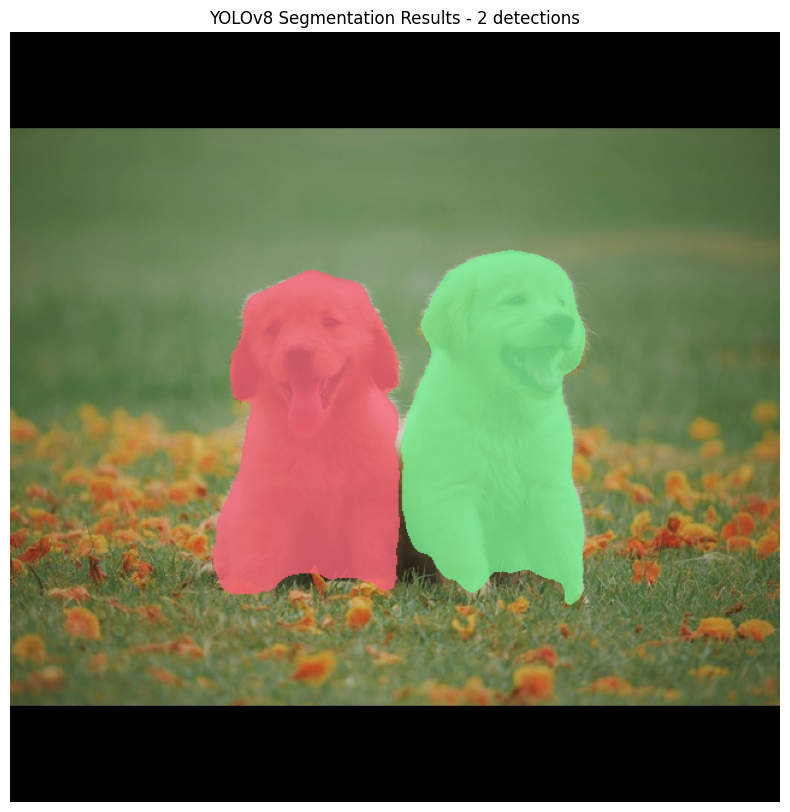


Detection Summary:
  1. dog: 0.743
  2. dog: 0.609


In [89]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from typing import Tuple, Optional

class YOLOv8SegmentationPostProcessor:
    def __init__(self, 
                 conf_threshold: float = 0.5, 
                 nms_threshold: float = 0.4,
                 input_size: Tuple[int, int] = (640, 640)):
        self.conf_threshold = conf_threshold
        self.nms_threshold = nms_threshold
        self.input_size = input_size
        
        self.class_names = [
            'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
            'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
            'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
            'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
            'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
            'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
            'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
            'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
            'hair drier', 'toothbrush'
        ]
        
    def load_raw_outputs(self, output0_path: str, output1_path: str) -> Tuple[np.ndarray, np.ndarray]:
        output0 = np.fromfile(output0_path, dtype=np.float32).reshape(1, 116, 8400)
        output1 = np.fromfile(output1_path, dtype=np.float32).reshape(1, 160, 160, 32)
        return output0, output1

    def decode_predictions(self, output0: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        predictions = output0[0]  # [116, 8400]
        boxes = predictions[:4, :]
        scores = predictions[4:84, :]
        mask_coeffs = predictions[84:, :]

        x_center, y_center, width, height = boxes
        x1 = x_center - width / 2
        y1 = y_center - height / 2
        x2 = x_center + width / 2
        y2 = y_center + height / 2
        boxes_xyxy = np.stack([x1, y1, x2, y2], axis=0)

        return boxes_xyxy, scores, mask_coeffs

    def filter_predictions(self, boxes, scores, mask_coeffs):
        max_scores = np.max(scores, axis=0)
        max_classes = np.argmax(scores, axis=0)
        valid_mask = max_scores > self.conf_threshold

        return (
            boxes[:, valid_mask],
            max_scores[valid_mask],
            max_classes[valid_mask],
            mask_coeffs[:, valid_mask]
        )

    def apply_nms(self, boxes, scores, classes, mask_coeffs):
        if len(scores) == 0:
            return boxes, scores, classes, mask_coeffs

        boxes_xywh = np.stack([
            boxes[0],
            boxes[1],
            boxes[2] - boxes[0],
            boxes[3] - boxes[1]
        ], axis=1)

        indices = cv2.dnn.NMSBoxes(
            bboxes=boxes_xywh.tolist(),
            scores=scores.tolist(),
            score_threshold=self.conf_threshold,
            nms_threshold=self.nms_threshold
        )

        if len(indices) > 0:
            indices = indices.flatten()
            return (
                boxes[:, indices],
                scores[indices],
                classes[indices],
                mask_coeffs[:, indices]
            )
        else:
            return (
                np.empty((4, 0)),
                np.empty((0,)),
                np.empty((0,)),
                np.empty((32, 0))
            )

    def generate_masks(self, mask_coeffs, proto_masks):
        if mask_coeffs.shape[1] == 0:
            return np.empty((0, 160, 160))
        proto_masks = proto_masks[0]  # [160, 160, 32]
        masks = np.einsum("hwd,dn->hwn", proto_masks, mask_coeffs)
        masks = 1 / (1 + np.exp(-masks))  # sigmoid
        masks = masks.transpose(2, 0, 1)  # [N, H, W]
        return masks

    def filter_masks_by_size(self, masks, boxes, min_mask_area=100):
        """Filter out masks that are too small or have low quality"""
        if masks.shape[0] == 0:
            return masks, np.arange(0)
        
        valid_indices = []
        for i, (mask, box) in enumerate(zip(masks, boxes.T)):
            # Calculate mask area
            mask_binary = (mask > 0.5).astype(np.uint8)
            mask_area = np.sum(mask_binary)
            
            # Calculate bounding box area
            box_area = (box[2] - box[0]) * (box[3] - box[1])
            
            # Filter based on minimum area and reasonable mask-to-box ratio
            if mask_area > min_mask_area and mask_area > 0.1 * box_area:
                valid_indices.append(i)
        
        if len(valid_indices) > 0:
            return masks[valid_indices], np.array(valid_indices)
        else:
            return np.empty((0, masks.shape[1], masks.shape[2])), np.array([])

    def scale_coordinates(self, boxes: np.ndarray, original_shape: Tuple[int, int]) -> np.ndarray:
        orig_h, orig_w = original_shape
        input_w, input_h = self.input_size

        gain = min(input_w / orig_w, input_h / orig_h)
        pad_w = (input_w - orig_w * gain) / 2
        pad_h = (input_h - orig_h * gain) / 2

        boxes_scaled = boxes.copy()
        boxes_scaled[[0, 2]] -= pad_w
        boxes_scaled[[1, 3]] -= pad_h
        boxes_scaled /= gain

        boxes_scaled[0::2] = boxes_scaled[0::2].clip(0, orig_w)
        boxes_scaled[1::2] = boxes_scaled[1::2].clip(0, orig_h)

        return boxes_scaled

    def resize_masks(self, masks, original_shape):
        if masks.shape[0] == 0:
            return np.empty((0, original_shape[0], original_shape[1]))

        orig_h, orig_w = original_shape
        resized_masks = [cv2.resize(mask, (orig_w, orig_h), interpolation=cv2.INTER_LINEAR) for mask in masks]
        return np.array(resized_masks)

    def clean_masks(self, masks, min_area_ratio=0.001):
        """Clean masks by removing small disconnected components"""
        cleaned_masks = []
        
        for mask in masks:
            # Convert to binary
            binary_mask = (mask > 0.6).astype(np.uint8)  # Higher threshold for better quality
            
            # Find connected components
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask)
            
            # Keep only the largest component (background is label 0)
            if num_labels > 1:
                # Find the largest component (excluding background)
                largest_component = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
                binary_mask = (labels == largest_component).astype(np.uint8)
            
            # Apply morphological operations to smooth the mask
            kernel = np.ones((3, 3), np.uint8)
            binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
            binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
            
            # Convert back to float and apply to original mask
            cleaned_mask = mask * binary_mask
            cleaned_masks.append(cleaned_mask)
        
        return np.array(cleaned_masks) if cleaned_masks else np.empty((0, masks.shape[1], masks.shape[2]))

    def process(self, output0_path: str, output1_path: str, original_image: np.ndarray) -> dict:
        output0, output1 = self.load_raw_outputs(output0_path, output1_path)
        boxes, scores, mask_coeffs = self.decode_predictions(output0)

        boxes, scores, classes, mask_coeffs = self.filter_predictions(boxes, scores, mask_coeffs)
        boxes, scores, classes, mask_coeffs = self.apply_nms(boxes, scores, classes, mask_coeffs)

        masks = self.generate_masks(mask_coeffs, output1)

        # Filter masks by size before scaling
        masks, valid_indices = self.filter_masks_by_size(masks, boxes)
        if len(valid_indices) > 0:
            boxes = boxes[:, valid_indices]
            scores = scores[valid_indices]
            classes = classes[valid_indices]

        orig_shape = original_image.shape[:2]
        boxes_scaled = self.scale_coordinates(boxes, orig_shape)
        resized_masks = self.resize_masks(masks, orig_shape)
        
        # Clean masks after resizing
        if resized_masks.shape[0] > 0:
            resized_masks = self.clean_masks(resized_masks)

        return {
            'boxes': boxes_scaled,
            'scores': scores,
            'classes': classes,
            'masks': resized_masks,
            'class_names': [self.class_names[int(cls)] for cls in classes]
        }

    def visualize_results(self, image: np.ndarray, results: dict, save_path: Optional[str] = None,
                        alpha: float = 0.8, mask_threshold: float = 0.6):
        """
        Visualize instance segmentation masks with strong per-instance colors over original image.
        """
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        overlay = image_rgb.copy()

        num_instances = len(results['masks'])
        if num_instances == 0:
            print("No valid detections found")
            return

        # Bright random color per instance
        # np.random.seed(42)
        colors = [np.random.randint(100, 256, size=3, dtype=np.uint8) for _ in range(num_instances)]

        for i, (mask, color) in enumerate(zip(results['masks'], colors)):
            mask_binary = (mask > mask_threshold).astype(np.uint8)

            if np.sum(mask_binary) < 100:
                continue

            color_mask = np.zeros_like(image_rgb)
            for c in range(3):
                color_mask[:, :, c] = mask_binary * color[c]

            mask_3d = np.stack([mask_binary]*3, axis=-1)
            overlay = np.where(mask_3d, 
                            (alpha * color_mask + (1 - alpha) * overlay).astype(np.uint8), 
                            overlay)

        # Plot
        plt.figure(figsize=(10, 10))
        plt.imshow(overlay)
        plt.title(f"YOLOv8 Segmentation Results - {num_instances} detections")
        plt.axis('off')

        if save_path:
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            cv2.imwrite(save_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
            print(f"Saved to {save_path}")

        plt.show()

        print("\nDetection Summary:")
        for i, (cls, score) in enumerate(zip(results["class_names"], results["scores"])):
            print(f"  {i+1}. {cls}: {score:.3f}")




# Example usage
def main():
    # Use higher confidence threshold to reduce false positives
    processor = YOLOv8SegmentationPostProcessor(conf_threshold=0.6, nms_threshold=0.4)

    image = cv2.imread("dogs.jpg")
    results = processor.process(
        output0_path="results/Result_0/output0.raw",
        output1_path="results/Result_0/output1.raw",
        original_image=image
    )

    # Use higher mask threshold for cleaner visualization
    processor.visualize_results(
        image,
        results,
        save_path="./segmentation_results.jpg",
        mask_threshold=0.7
    )

if __name__ == "__main__":
    main()

In [24]:
import cv2
import numpy as np

img = cv2.imread("airplane.jpeg")   
img = cv2.resize(img, (640, 640))                      
cv2.imwrite("airplane_resized.jpg", img)                      

True

In [5]:
from ultralytics import YOLO
import os
import cv2
import numpy as np

# Load pretrained YOLOv8 instance segmentation model
model = YOLO('yolov8n-seg.pt')

# Path to input image
image_path = 'dogs.jpg'  # Replace with your actual image file name
results = model(image_path)
result = results[0]

# Load original image
original_image = cv2.imread(image_path)

# Convert image from BGR to RGB
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Generate random colors for each instance
num_instances = len(result.masks.data)
colors = [np.random.randint(0, 255, size=3).tolist() for _ in range(num_instances)]

# Create empty mask overlay
mask_overlay = np.zeros_like(original_image, dtype=np.uint8)

# Intensity multiplier for stronger mask colors
intensity_multiplier = 1.8  # You can try 1.5 to 2.0

# Draw each mask in its color (with higher intensity)
for mask_tensor, color in zip(result.masks.data, colors):
    mask = mask_tensor.cpu().numpy()
    mask = (mask > 0.5).astype(np.uint8)  # Binarize the mask

    # Intensify the color
    intense_color = (np.array(color) * intensity_multiplier).clip(0, 255).astype(np.uint8)
    color_layer = np.zeros_like(original_image, dtype=np.uint8)
    color_layer[:, :, 0] = intense_color[0]
    color_layer[:, :, 1] = intense_color[1]
    color_layer[:, :, 2] = intense_color[2]

    # Apply color to the mask
    mask_expanded = np.stack([mask] * 3, axis=-1)
    mask_colored = color_layer * mask_expanded

    # Add to overlay
    mask_overlay = cv2.add(mask_overlay, mask_colored)

# Blend original image and mask overlay
alpha = 0.5  # Controls how strong the overlay is visually
output_image = cv2.addWeighted(original_image, 1 - alpha, mask_overlay, alpha, 0)

# Convert back to BGR for saving with OpenCV
output_image = cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR)

# Save the result
output_folder = 'output_folder'
os.makedirs(output_folder, exist_ok=True)
output_path = os.path.join(output_folder, 'instance_segmentation_result.jpg')
cv2.imwrite(output_path, output_image)

print(f"Saved instance segmentation result to: {output_path}")


image 1/1 /home/likhiths/Mini-Project/InstaceSeg-Yolov8/dogs.jpg: 640x640 2 dogs, 85.1ms
Speed: 1.3ms preprocess, 85.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
Saved instance segmentation result to: output_folder/instance_segmentation_result.jpg


In [3]:
from ultralytics import YOLO
import os
import cv2
import numpy as np

# Load pretrained YOLOv8 instance segmentation model
model = YOLO('yolov8n-seg.pt')

# Path to input image
image_path = 'dogs.jpg'  # Replace with your actual image file name
results = model(image_path)
result = results[0]

# Load original image
original_image = cv2.imread(image_path)

# Convert image from BGR to RGB
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Generate random colors for each instance
num_instances = len(result.masks.data)
colors = [np.random.randint(0, 255, size=3).tolist() for _ in range(num_instances)]

# Create empty mask overlay
mask_overlay = np.zeros_like(original_image_rgb, dtype=np.uint8)

# Intensity multiplier for stronger mask colors
intensity_multiplier = 33.0 # Adjust if needed

# Draw each mask in its color (with higher intensity)
for mask_tensor, color in zip(result.masks.data, colors):
    mask = (mask_tensor.cpu().numpy() > 0.5).astype(np.uint8)

    # Intensify the color
    intense_color = (np.array(color) * intensity_multiplier).clip(0, 255).astype(np.uint8)

    # Create color layer
    color_layer = np.zeros_like(original_image_rgb, dtype=np.uint8)
    color_layer[:, :, 0] = intense_color[0]
    color_layer[:, :, 1] = intense_color[1]
    color_layer[:, :, 2] = intense_color[2]

    # Apply color only where mask is
    mask_expanded = np.stack([mask]*3, axis=-1)
    mask_colored = color_layer * mask_expanded

    # Add to mask overlay
    mask_overlay = cv2.add(mask_overlay, mask_colored)

# Create combined mask of all instances
combined_mask = np.zeros(original_image_rgb.shape[:2], dtype=np.uint8)
for mask_tensor in result.masks.data:
    mask = (mask_tensor.cpu().numpy() > 0.5).astype(np.uint8)
    combined_mask = np.maximum(combined_mask, mask)

# Convert combined mask to 3 channels
combined_mask_3ch = np.stack([combined_mask]*3, axis=-1)

# Copy original image to output
output_image_rgb = original_image_rgb.copy()

# Apply overlay only on masked areas
alpha = 0.5  # Controls mask transparency
masked_indices = combined_mask_3ch == 1
output_image_rgb[masked_indices] = (
    original_image_rgb[masked_indices] * (1 - alpha) +
    mask_overlay[masked_indices] * alpha
).astype(np.uint8)

# Convert back to BGR for saving with OpenCV
output_image_bgr = cv2.cvtColor(output_image_rgb, cv2.COLOR_RGB2BGR)

# Save the result
output_folder = 'output_folder'
os.makedirs(output_folder, exist_ok=True)
output_path = os.path.join(output_folder, 'instance_segmentation_result.jpg')
cv2.imwrite(output_path, output_image_bgr)

print(f"Saved instance segmentation result to: {output_path}")

100%|██████████| 6.74M/6.74M [00:02<00:00, 2.65MB/s]



image 1/1 /home/likhiths/Mini-Project/InstaceSeg-Yolov8/dogs.jpg: 640x640 2 dogs, 149.8ms
Speed: 2.5ms preprocess, 149.8ms inference, 8.9ms postprocess per image at shape (1, 3, 640, 640)
Saved instance segmentation result to: output_folder/instance_segmentation_result.jpg
